In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import pandas as pd

In [18]:
Image_size=256
Batch_size=32
Channels=3
Epochs=25

In [19]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 12446 files belonging to 4 classes.


In [20]:
class_names=dataset.class_names
print(class_names)
print(len(dataset))

['Cyst', 'Normal', 'Stone', 'Tumor']
389


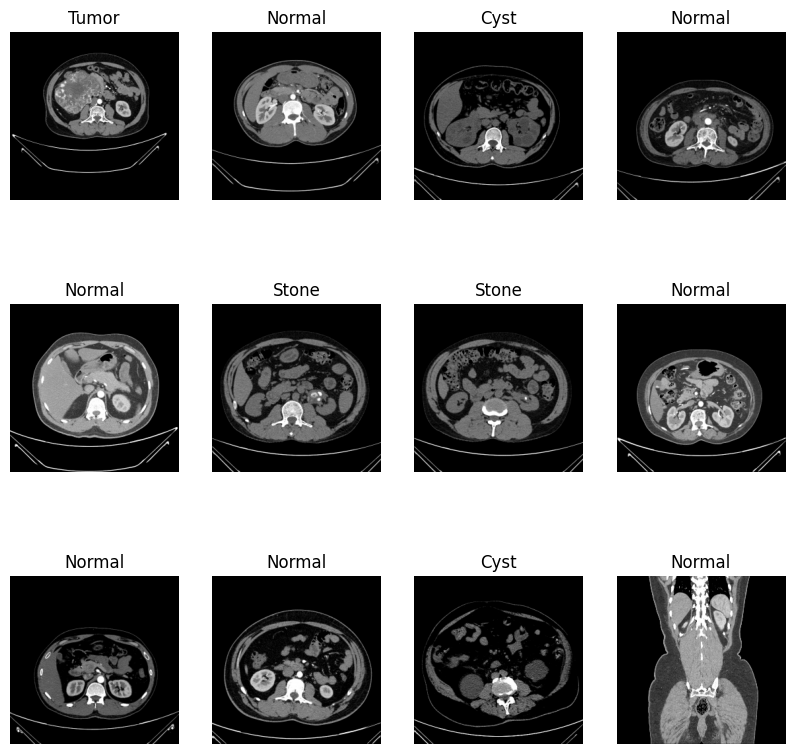

In [21]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [22]:
# Train , Test Split 80%==>Train 10%==>Test 10%==>Validation
train_size=0.8
Train_dataset=dataset.take(311) # Train dataset
print(len(Train_dataset))
Test_dataset=dataset.skip(311) # Test dataset
#print(len(Test_dataset))
Val_dataset=Test_dataset.take(39) # Validation dataset
print(len(Val_dataset))
Test_dataset=Test_dataset.skip(39)
print(len(Test_dataset))


311
39
39


In [23]:
# Cacheing and prefetching
Train_dataset=Train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Test_dataset=Test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_dataset=Val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resizing_rescaling=tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
# Data Augmentation
data_agumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [26]:
# Model Building
Input_shape=(Batch_size,Image_size,Image_size,Channels)
n_classes=4
model=models.Sequential([
    resizing_rescaling,
    data_agumentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=Input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=Input_shape)

In [27]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history=model.fit(
    Train_dataset,
    epochs=25,
    batch_size=Batch_size,
    verbose=1,
    validation_data=Val_dataset
)

Epoch 1/25


311/311 [==============================] - 108s 270ms/step - loss: 1.3393 - accuracy: 0.6496 - val_loss: 0.7315 - val_accuracy: 0.7340
Epoch 2/25
311/311 [==============================] - 74s 237ms/step - loss: 0.5181 - accuracy: 0.8085 - val_loss: 0.3859 - val_accuracy: 0.8542
Epoch 3/25
311/311 [==============================] - 74s 237ms/step - loss: 0.3395 - accuracy: 0.8782 - val_loss: 0.2769 - val_accuracy: 0.9022
Epoch 4/25
311/311 [==============================] - 73s 236ms/step - loss: 0.2511 - accuracy: 0.9099 - val_loss: 0.2818 - val_accuracy: 0.8982
Epoch 5/25
311/311 [==============================] - 73s 236ms/step - loss: 0.1921 - accuracy: 0.9314 - val_loss: 0.2255 - val_accuracy: 0.9199
Epoch 6/25
311/311 [==============================] - 75s 240ms/step - loss: 0.1571 - accuracy: 0.9446 - val_loss: 0.2480 - val_accuracy: 0.9046
Epoch 7/25
311/311 [==============================] - 74s 238ms/step - loss: 0.1290 - accuracy: 0.9566 - val_loss: 0.1466 - val_accuracy: 0.

<AxesSubplot:>

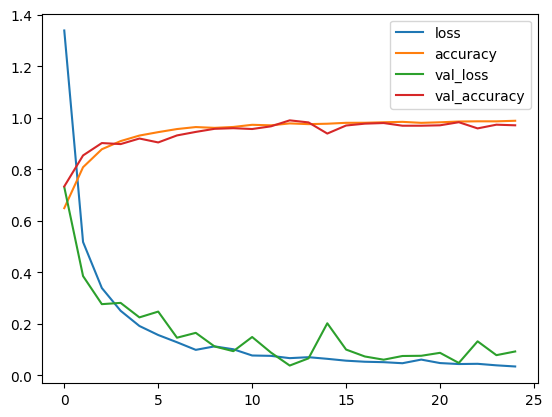

In [30]:
history_df=pd.DataFrame(history.history)
history_df.plot()

In [31]:
scores=model.evaluate(Test_dataset)
scores

39/39 [==============================] - 12s 43ms/step - loss: 0.0535 - accuracy: 0.9775


[0.05354844406247139, 0.9775280952453613]

In [32]:
scores=model.evaluate(Train_dataset)
scores

311/311 [==============================] - 10s 33ms/step - loss: 0.0725 - accuracy: 0.9760


[0.07249296456575394, 0.9759847521781921]

In [33]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidance=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidance

1/1 [==============================] - 0s 24ms/step


(-0.5, 255.5, 255.5, -0.5)

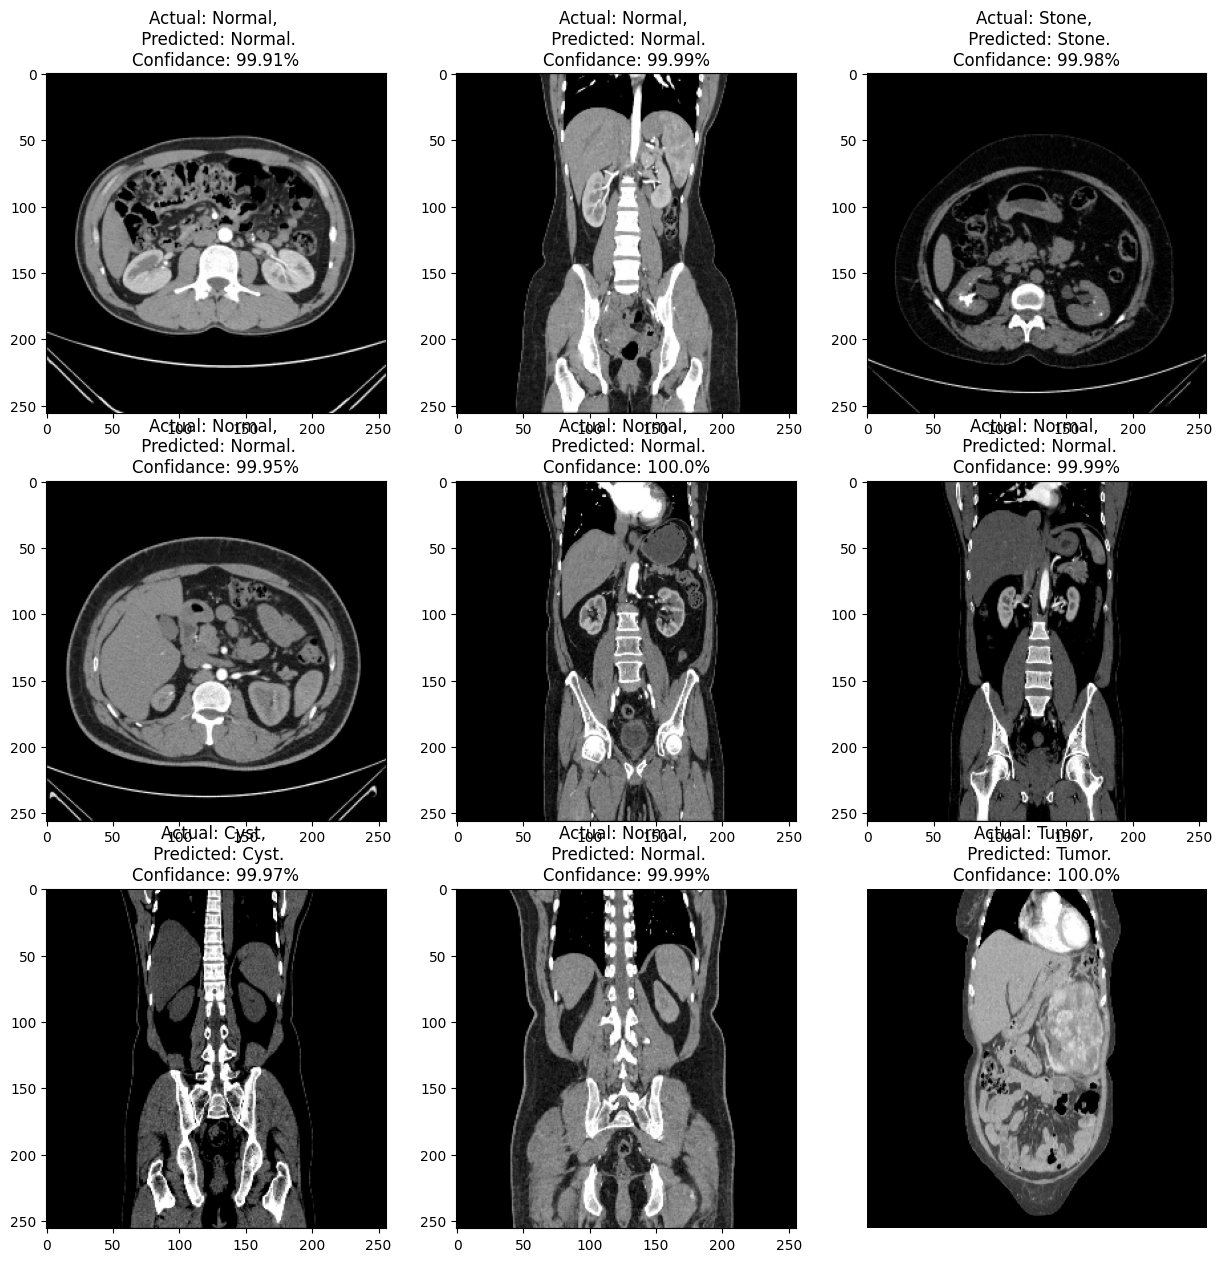

In [34]:
plt.figure(figsize=(15,15))
for images, labels in Test_dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidance=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\nConfidance: {confidance}%")
plt.axis("off")

In [35]:
import os
model_version=max([int(i) for i in os.listdir("./models")+[0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets


INFO:tensorflow:Assets written to: ./models/2\assets
